Lab01-3
======

### Context
#### Clustering
+ Clustering Evaluation

# Clustering Evaluation
이번 수업에서는 클러스터링 알고리즘을 평가하는 방법에 대해 알아보도록 하겠습니다.

### 1. Silhouette
+ 실루엣 값은 한 클러스터 안의 데이터들이 다른 클러스터와 비교해서 얼마나 비슷한가를 나타냅니다.<br>
+ 같은 클러스터 내의 점들간 거리는 가깝고(cohesion) 서로 다른 클러스터 간의 거리는 멀수록(separation) 높은 값을 얻을 수 있습니다.<br>
+ 실루엣 값이 1에 근접한다는 것은 같은 클러스터 내의 평균거리가 다른 클러스터와의 평균거리보다 가깝다는 것을 의미합니다.
+ 일반적으로 실루엣 값이 0.5보다 크다면 데이터가 잘 클러스터링 되었다는 것을 나타냅니다.

실루엣 공식은 다음과 같습니다.
$$ S_i = { {(b_i - a_i)} \over max(a_i, b_i) }$$

$$ a_i\ :\ 같은\ 클러스터\ 내의\ 모든\ 점들\ 간\ 평균거리 $$
$$ b_i\ :\ \bar d\ =\ (i,c)의\ 최솟값 $$
$$ \bar d\ =\ (i,c)\ :\ 다른\ 클러스터\ c와\ i번째 데이터 와의\ 평균거리$$
<br>

직관적으로 수식을 이해해보겠습니다. a<sub>i</sub>는 같은 클러스터 내의 데이터 들이 잘 모여있다면 적은 값을 나타내고, b<sub>i</sub>는 각 클러스터들이 멀리 떨어져있다면 큰 값을 나타내게 됩니다.<br>
따라서 수식 S<sub>i</sub>에 따르면, 아주 잘 형성된(같은 클러스터는 가깝고 다른 클러스터끼리는 먼) 클러스터 형태일 때 분모는 b<sub>i</sub>이 되고,<br> 분자는 b<sub>i</sub>에서 아주 작은 값인 a<sub>i</sub>가 빠져 1에 가까운 실루엣 값을 얻을 수 있습니다.


In [1]:
from os.path import join
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import random
import time

datapath = join('data','wine.txt')
labelpath = join('data','wine_attributes.txt')

columns = list()
with open(labelpath, 'r') as f:
    columns = f.read().split('\n')

## 1. 데이터 살펴보기
이번 챕터에서는 우리가 사용할 데이터는 178개의 행과 14개의 열로 이루어진 와인 데이터를 사용해보려고 합니다.
<br>데이터를 살펴보기 쉽게 pandas DataFrame으로 읽습니다.

In [2]:
data = pd.read_csv(datapath, names = columns)
del data['Class']

DataFrame.head() 함수로 처음 5개의 데이터를 살펴볼 수 있습니다.

In [3]:
data.head()

,Alcohol,Malic acid,Ash,Alcalinity of ash,Magnesium,Total phenols,Flavanoids,Nonflavanoid phenols,Proanthocyanins,Color intensity,Hue,OD280/OD315 of diluted wines,Proline
0,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


와인 데이터는 3개의 클래스로 이루어진 데이터이므로 3개의 클러스터를 형성해 보도록 하겠습니다.
<br>마지막에 이번 예제에서 형성한 클러스터가 잘 형성되었는지를 확인하기 위해 실제 클래스를 변수로 저장해둡니다.

 ## 2. 간단한 전처리 및 준비

### 차원 축소 
wine 데이터는 13개의 컬럼을 가지고 있고, 하나의 데이터(행)는 13개의 차원으로 이루어진 벡터라고 볼 수 있습니다. <br>
13차원은 우리 눈으로 볼 수 있도록 표현하기 어려우므로 아직 배우진 않았지만, PCA를 사용해 2차원으로 줄여 시각화할 수 있도록 합니다.

In [4]:
for dim in data.columns:
        data[dim] -= np.min(data[dim])
        data[dim] /= np.max(data[dim])
        
pca = PCA(n_components=2)
pca.fit(data)
data = pca.transform(data)

In [5]:
N = len(data)
print('데이터의 개수는 {}개 입니다.'.format(N))

데이터의 개수는 178개 입니다.


In [6]:
def get_centroid(data, label, n_clusters):
    centroid = list()
    for i in range(n_clusters):
        x = data[label == i][:,0]
        y = data[label == i][:,1]
        x = np.mean(x)
        y = np.mean(y)
        centroid.append([x,y])
    return np.array(centroid)

def silhouette(X, model, name, **kw):
    max_silhouette_score = -1
    max_cluster = 0
    for n_clusters in range(2,10):
    # 1행에 2개의 그림을 그릴 수 있도록 설정합니다.
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.set_size_inches(10, 5)

        # 처음 나오는 그림은 실루엣 plot 입니다.
        # 실루엣 계수는 -1 ~ 1범위로 나타낼 수 있지만, 이번 예제에서는 범위를 -0.1 ~ 1로 지정합니다.
        ax1.set_xlim([-0.1, 1])
        # 클러스터 개수 별 사이의 간격
        ax1.set_ylim([0, len(data) + (n_clusters + 1) * 10])

        # 클러스터링 실행
        clusterer = model(n_clusters = n_clusters, **kw).fit(data)
        cluster_labels = clusterer.labels_
        # 실루엣 점수는 각 샘플 당 평균 점수로 주어집니다.
        silhouette_avg = silhouette_score(data, cluster_labels)
        print("클러스터의 수 = {}, 평균 실루엣 score : {:.3f}".format(n_clusters,silhouette_avg))
        if max_silhouette_score < silhouette_avg :
            max_silhouette_score = silhouette_avg
            max_cluster = n_clusters
        # 모든 샘플에 대해 실루엣 점수 계산
        sample_silhouette_values = silhouette_samples(data, cluster_labels)

        y_lower = 10
        for i in range(n_clusters):
            # 클러스터 i 에 속한 샘플들의 실루엣 점수를 모아 점수에 따라 정렬합니다.
            ith_cluster_silhouette_values = \
                sample_silhouette_values[cluster_labels == i]

            ith_cluster_silhouette_values.sort()

            size_cluster_i = ith_cluster_silhouette_values.shape[0]
            y_upper = y_lower + size_cluster_i

            color = cm.nipy_spectral(float(i) / n_clusters)
            ax1.fill_betweenx(np.arange(y_lower, y_upper),
                              0, ith_cluster_silhouette_values,
                              facecolor=color, edgecolor=color, alpha=0.7)

            # 실루엣 plot에 클러스터 라벨을 달아줍니다.
            ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

            # 다음 클러스터의 실루엣 plot을 그리기 위해 간격을 추가합니다.
            y_lower = y_upper + 10 
        ax1.set_title("The silhouette plot for the various clusters.")
        ax1.set_xlabel("The silhouette coefficient values")
        ax1.set_ylabel("Cluster label")

        # 평균 실루엣 score를 표시할 빨간 세로 점선을 그려줍니다.
        ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

        ax1.set_yticks([])  # y축에 표시되는 값들을 제거해줍니다.
        ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

        # 두 번째 그림은 실제로 클러스터링 된 데이터를 보여줍니다
        colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
        ax2.scatter(data[:, 0], data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                    c=colors, edgecolor='k')

        # 클러스터에 라벨을 달아주기 위해 중심점을 얻어냅니다. 
        centers = get_centroid(data, cluster_labels, n_clusters)
        # 각 클러스터 중심점에 클러스터 라벨을 달아줍니다.
        ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                    c="white", alpha=1, s=200, edgecolor='k')

        for i, c in enumerate(centers):
            ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                        s=50, edgecolor='k')

        ax2.set_title("The visualization of the clustered data.")
        ax2.set_xlabel("Feature space for the 1st feature")
        ax2.set_ylabel("Feature space for the 2nd feature")

        plt.suptitle(("Silhouette analysis for {} clustering on sample data ".format(name),
                      "with n_clusters = %d" % n_clusters),
                     fontsize=14, fontweight='bold')
    print("가장 높은 실루엣 score를 가진 클러스터 수 : {}, 실루엣 score : {:.3f}".format(max_cluster, max_silhouette_score))
    plt.show()


## 4. 실루엣으로 클러스터링 알고리즘 평가해보기
### 1) k-means Clustering


클러스터의 수 = 2, 평균 실루엣 score : 0.493
클러스터의 수 = 3, 평균 실루엣 score : 0.568
클러스터의 수 = 4, 평균 실루엣 score : 0.490
클러스터의 수 = 5, 평균 실루엣 score : 0.459
클러스터의 수 = 6, 평균 실루엣 score : 0.428
클러스터의 수 = 7, 평균 실루엣 score : 0.382
클러스터의 수 = 8, 평균 실루엣 score : 0.372
클러스터의 수 = 9, 평균 실루엣 score : 0.386
가장 높은 실루엣 score를 가진 클러스터 수 : 3, 실루엣 score : 0.568


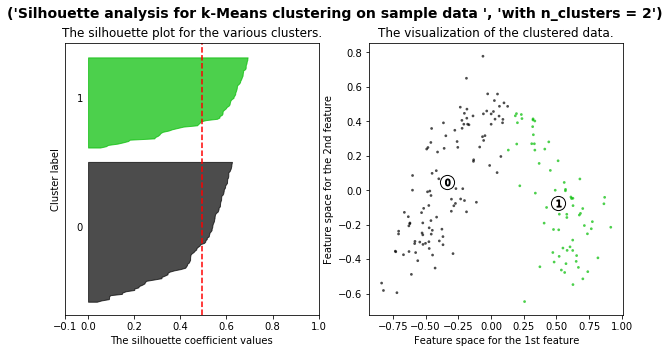

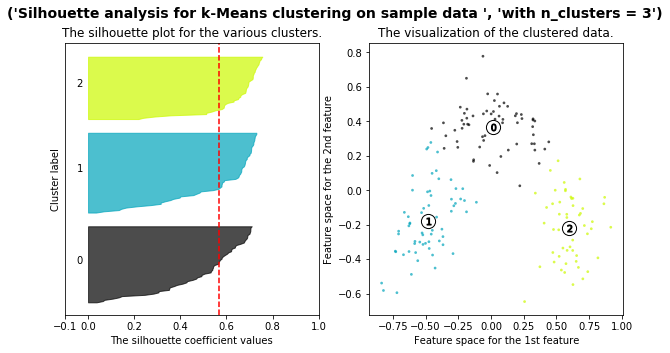

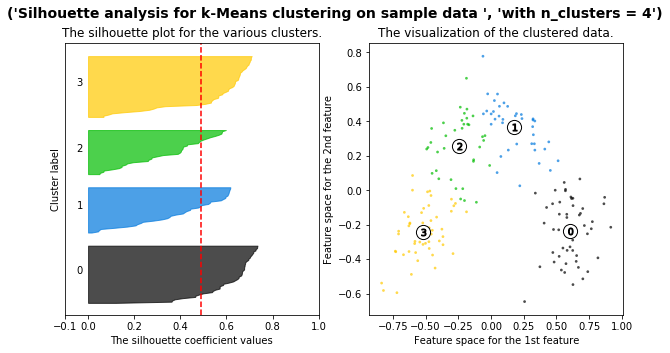

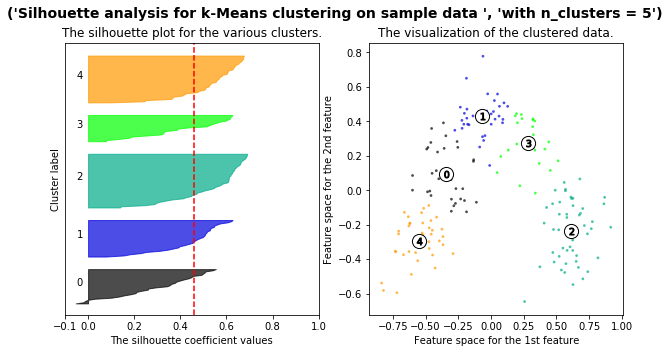

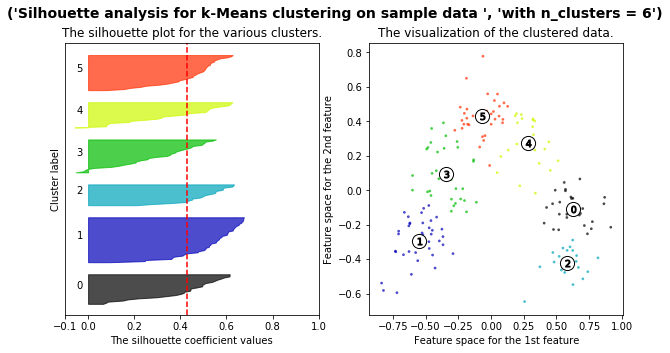

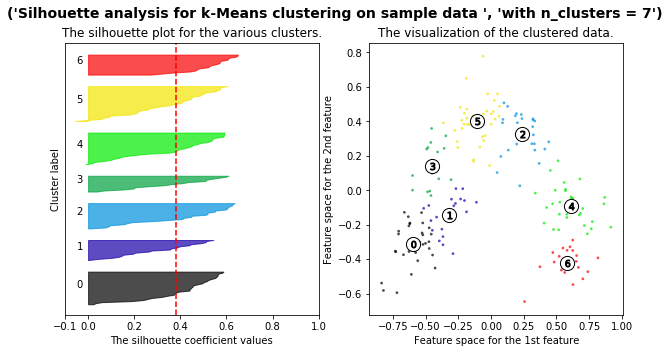

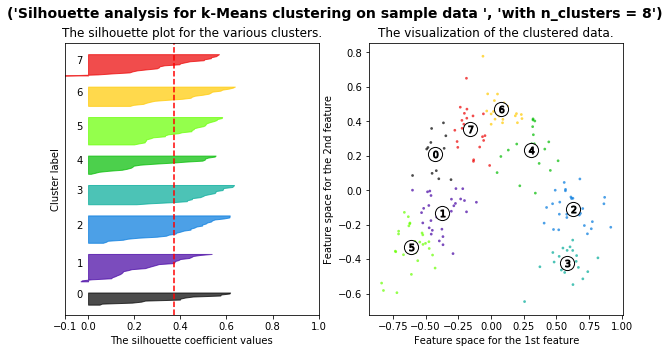

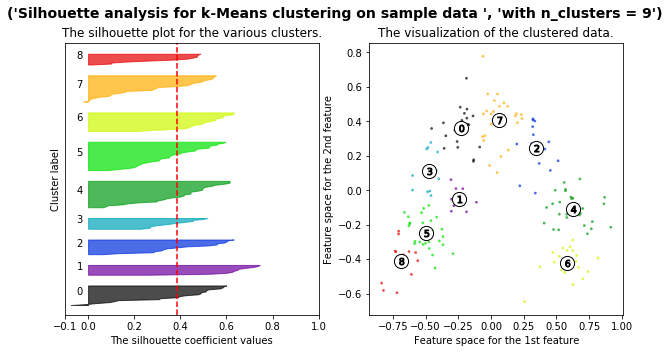

In [7]:
silhouette(data, KMeans, 'k-Means', init='random')

### 2) Hierarchical Clustering
#### (1) Single Linkage - 두 클러스터 내의 가장 가까운 점 사이의 거리

클러스터의 수 = 2, 평균 실루엣 score : 0.485
클러스터의 수 = 3, 평균 실루엣 score : 0.557
클러스터의 수 = 4, 평균 실루엣 score : 0.483
클러스터의 수 = 5, 평균 실루엣 score : 0.423
클러스터의 수 = 6, 평균 실루엣 score : 0.374
클러스터의 수 = 7, 평균 실루엣 score : 0.344
클러스터의 수 = 8, 평균 실루엣 score : 0.337
클러스터의 수 = 9, 평균 실루엣 score : 0.366
가장 높은 실루엣 score를 가진 클러스터 수 : 3, 실루엣 score : 0.557


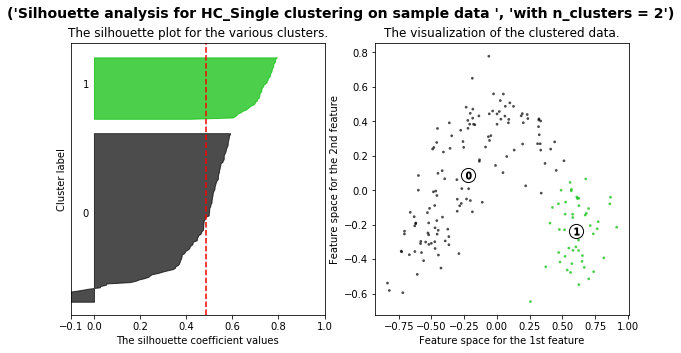

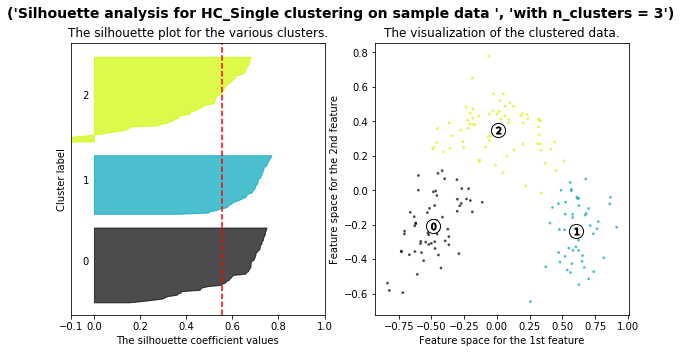

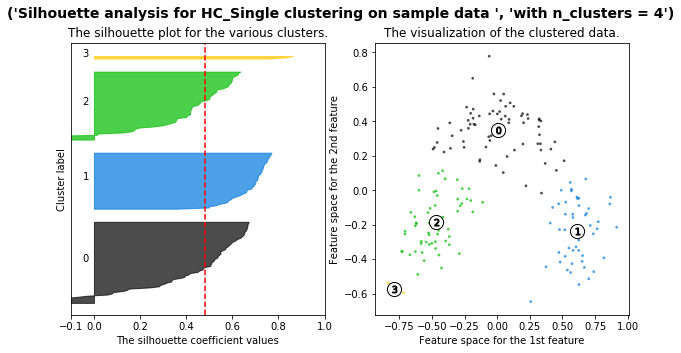

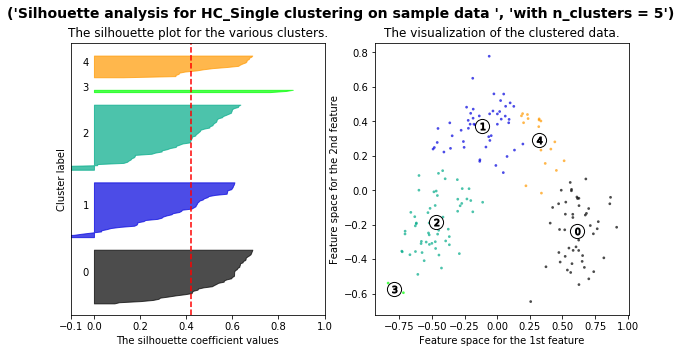

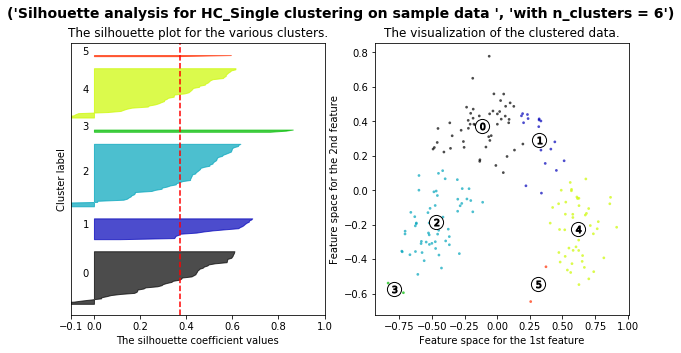

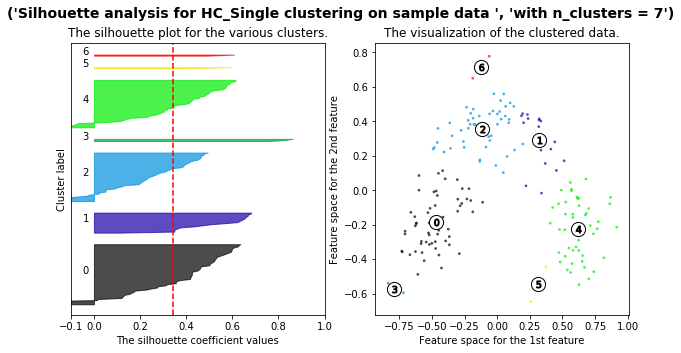

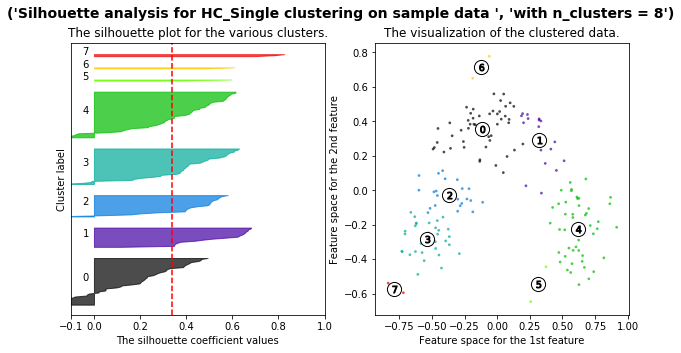

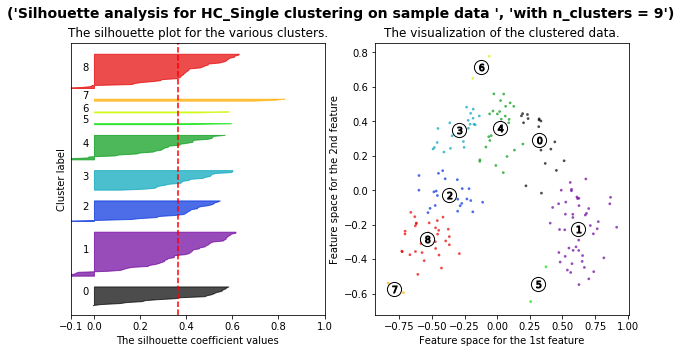

In [8]:
silhouette(data, AgglomerativeClustering, 'HC_Single', linkage='average')

### 2. Complete Linkage - 두 클러스터 내의 가장 먼 점 사이의 거리

클러스터의 수 = 2, 평균 실루엣 score : 0.374
클러스터의 수 = 3, 평균 실루엣 score : 0.495
클러스터의 수 = 4, 평균 실루엣 score : 0.479
클러스터의 수 = 5, 평균 실루엣 score : 0.403
클러스터의 수 = 6, 평균 실루엣 score : 0.337
클러스터의 수 = 7, 평균 실루엣 score : 0.258
클러스터의 수 = 8, 평균 실루엣 score : 0.297
클러스터의 수 = 9, 평균 실루엣 score : 0.343
가장 높은 실루엣 score를 가진 클러스터 수 : 3, 실루엣 score : 0.495


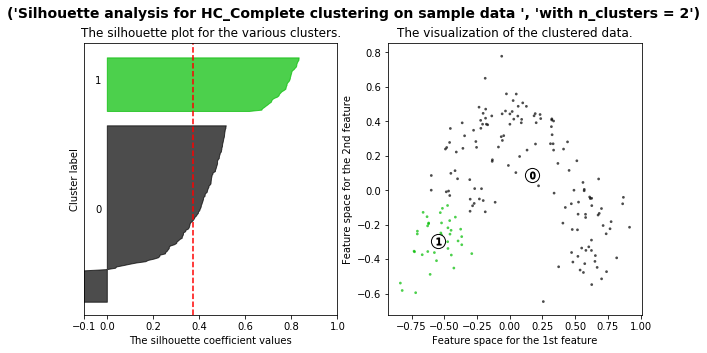

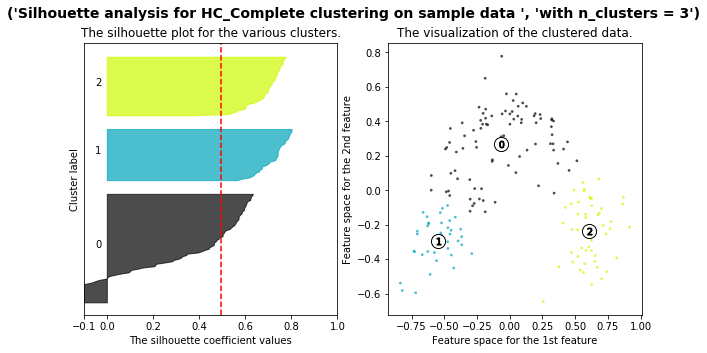

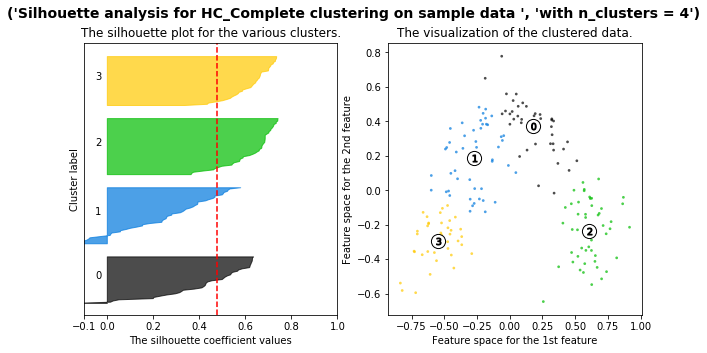

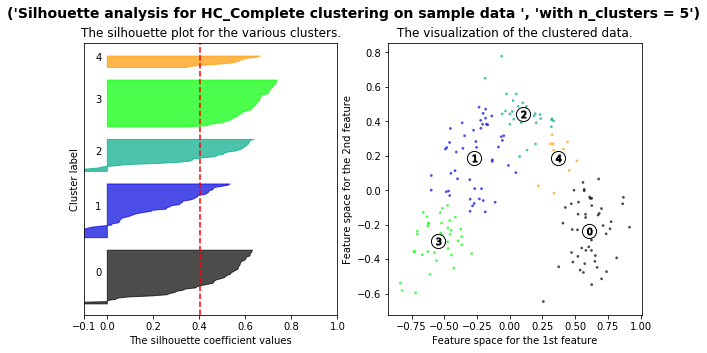

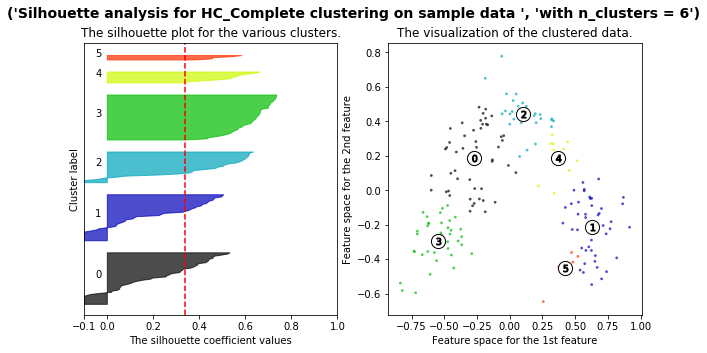

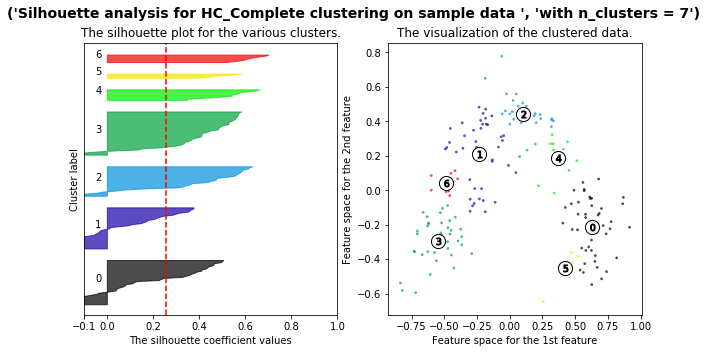

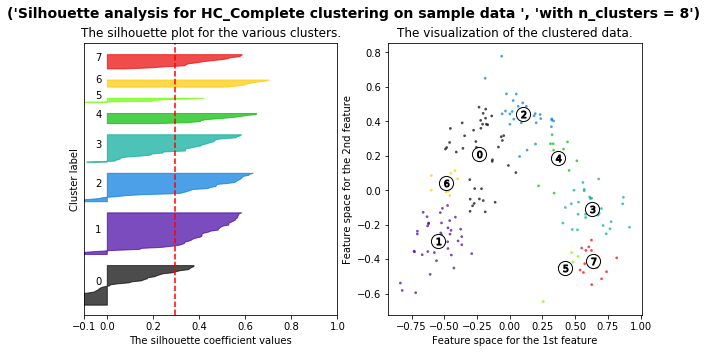

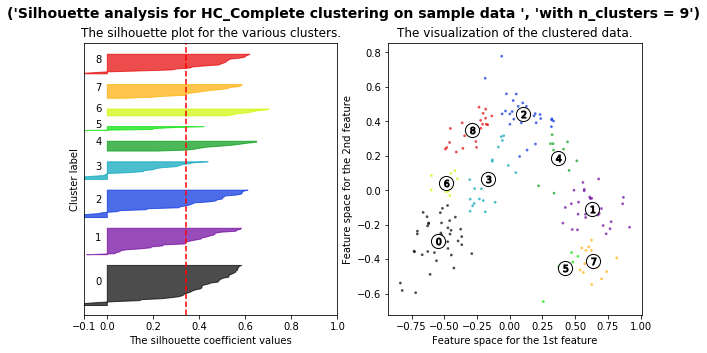

In [9]:
silhouette(data, AgglomerativeClustering, 'HC_Complete', linkage='complete')

### 3.  Average Linkage - 두 클러스터 내의 모든 점 사이의 평균 거리

클러스터의 수 = 2, 평균 실루엣 score : 0.485
클러스터의 수 = 3, 평균 실루엣 score : 0.557
클러스터의 수 = 4, 평균 실루엣 score : 0.483
클러스터의 수 = 5, 평균 실루엣 score : 0.423
클러스터의 수 = 6, 평균 실루엣 score : 0.374
클러스터의 수 = 7, 평균 실루엣 score : 0.344
클러스터의 수 = 8, 평균 실루엣 score : 0.337
클러스터의 수 = 9, 평균 실루엣 score : 0.366
가장 높은 실루엣 score를 가진 클러스터 수 : 3, 실루엣 score : 0.557


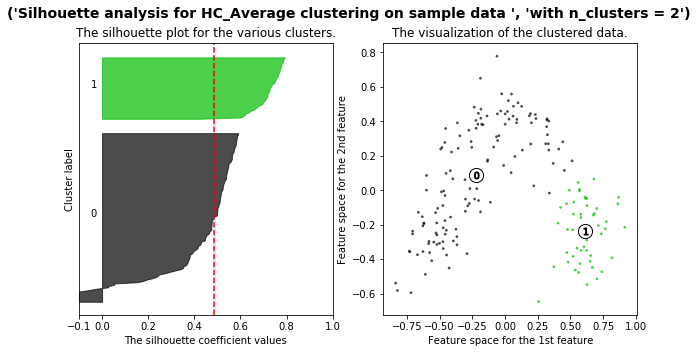

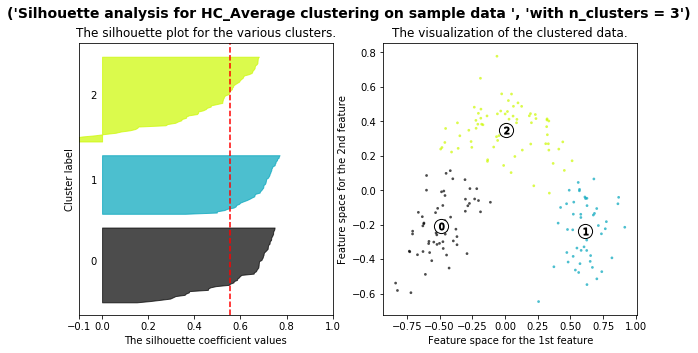

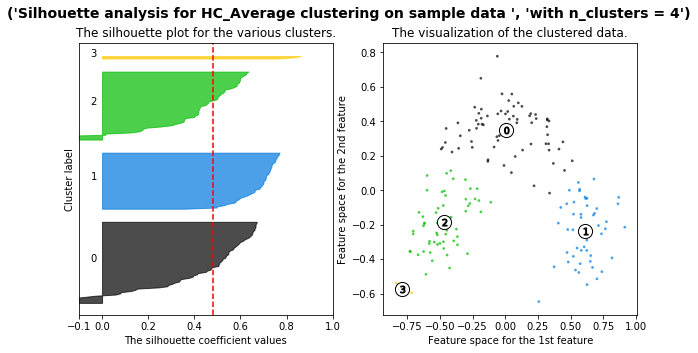

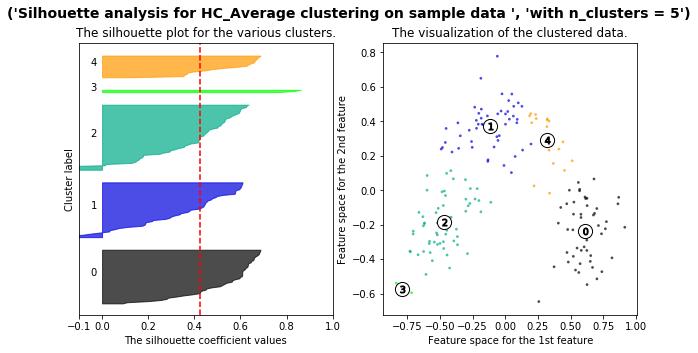

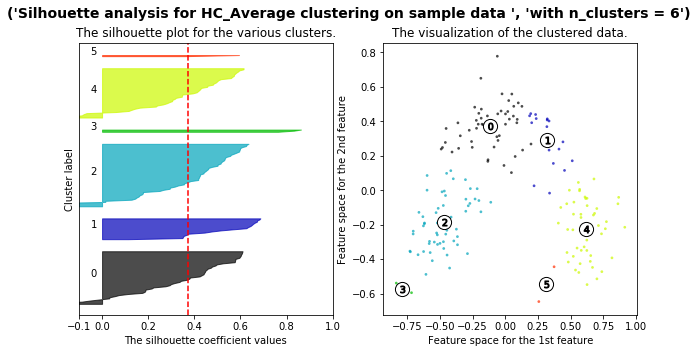

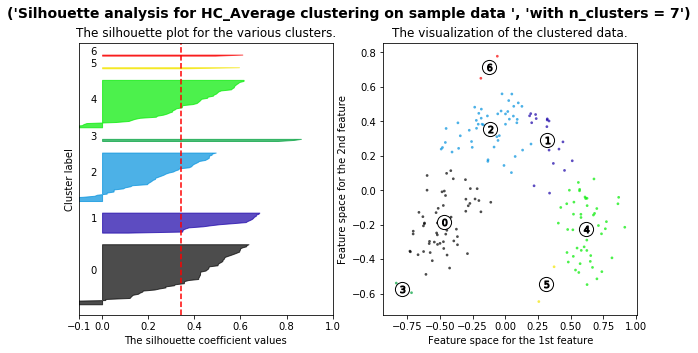

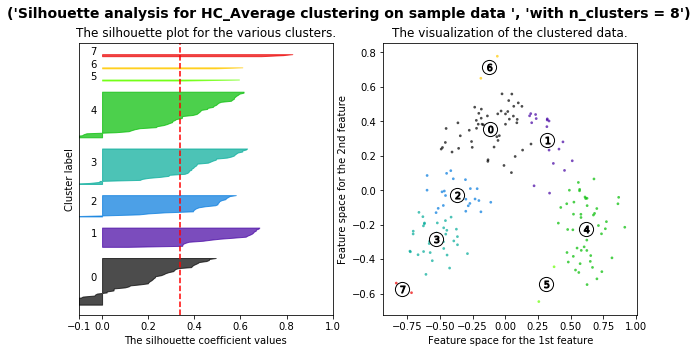

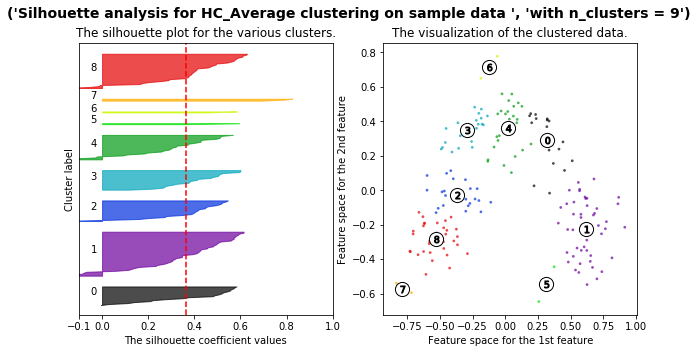

In [10]:
silhouette(data, AgglomerativeClustering, 'HC_Average', linkage='average')

### Reference

- Sklearn PCA - https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html
- Sklearn Silhouette Score Example - https://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html#sphx-glr-auto-examples-cluster-plot-kmeans-silhouette-analysis-py
- Silhouette Score - http://astralworld58.tistory.com/59
